# 1. Import and Install Dependencies

In [1]:
import cv2
import numpy as np
import os
import mediapipe as mp
import pandas as pd
#import torch

from matplotlib import pyplot as plt

# 2. Keypoints using MediaPipe Hands

Importiamo il modello Hands di MediaPipe

In [2]:
mp_hands = mp.solutions.hands # Hands model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities
mp_drawing_styles = mp.solutions.drawing_styles

funzione di riconoscimento: convertiamo prima l'immagine dal canale BGR (output di OpenCV feed) a quello RGB, necessario per MediaPipe;
alla fine riconvertiamo in BGR

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction with the Holistic/Hands model
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

# 3. Extract Keypoint Function

Il nostro scopo è quello di estrarre i keypoints delle mani riconosciute in un certo frame: tali keypoints saranno utili per il **riconoscimento** dei gesti e dei segni di interesse
- i keypoints, o anche **landmarks** ("punti di riferimento") si riferiscono a dei punti specifici di un'immagine, e vengono utilizzati per identificare dei punti/regioni importanti dell'oggetto o della parte del corpo riconosciuta nell'immagine

    - i landmark sono identificati da un algoritmo di rilevamento: nel nostro caso useremo l'algoritmo di MediaPipe che ci consente di identificare fino a 21 diversi landmark per ogni **mano** riconosciuta 

Lavoriamo su ciascun landkmark: 

- creiamo degli array dove memorizzare le sue coordinate (del landmark);

- useremo degli array di zero quando una certa parte del corpo non è riconosciuta/presente, per non fare andare in errore il sistema.

Definiamo una funzione che restituisce il numero dei keypoints riconosciuti per entrambe le mani:

In [4]:
def extract_keypoints_hands(results, hand_landmarks):
    h = np.array([[res.x, res.y, res.z] for res in hand_landmarks.landmark]).flatten() if results.multi_hand_landmarks else np.zeros(21*3)    
    return h

**N.B.** usiamo *flatten()* perchè vogliamo un solo array, unidimensionale, perchè ci servirà questo formato per la LSTM; infatti, senza flatten() avremo una matrice, un array bidimensionale (ciascun landmark avrà *x* valori associati)

Nello specifico:

- *res.x*, *res.y*, *res.z* sono i singoli valori delle coordinate di ciascun landmark, i quali verranno inseriti in un array più grande, ciclando per ogni landmark identificato:

    - come detto precedentemente, se non esistono coordinate per un landmark quella regione della mano non è riconosciuta: in tal caso viene creato un array vuoto

# 4. Datasets structure

Poichè abbiamo **due** dataset da cui attingere per il riconoscimento dei gesti, divideremo il file notebook, per ogni sezione, in due sotto-sezioni differenti. I dataset a disposizione sono i seguenti:
- **EgoGesture**
- **HaGRID**

Vediamo brevemente la loro organizzazione.

## 4.1. EgoGesture structure

Quali sono i gesti di interesse contenuti nel dataset?

In [5]:
ego_labels = np.array(["Photo Frame", "Applaud", "Heart"])

infatti, i valori assegnati a ogni label (classe) sul dataset sono i seguenti:

- photo frame: 23
- mano del gaucho: 38
- applaud: 52
- heart: 53

Creiamo delle strutture dati che ci risulteranno particolarmente utili nelle sezioni successive:

In [6]:
labels_num = [23, 52, 53]
label_dict = {23: 0, 52: 1, 53: 2}
label_dict_string = {23: "Photo Frame", 52: "Applaud", 53: "Heart"}

Essendoci 50 soggetti, 6 scene e 83 gesti diversi, in media avremo che uno stesso soggetto eseguirà gli 83 gesti 6 volte, una volta per ogni diversa scena; quindi uno stesso gesto sarà eseguito circa 50 * 6 = **300** volte.

Poichè includeremo successivamente uno step di *Data Augmentation*, raddoppiando i video tramite un flip, attorno all'asse y, di ciascun frame, le esecuzioni saranno infine circa **50000**.

Noi siamo interessati solamente a **4** gesti su 83, quindi avremo in totale **2400** esecuzioni diverse (*4 * 6 * 50 * 2*) , ovvero quasi **600** esecuzioni per ognuno dei 4 gesti.

Definiamo delle liste di stringhe che conterranno i corrispondenti soggetti per l'insieme di **train**, **test** e **validation**:

In [7]:
train_subjects_string = ["subject03", "subject04","subject05","subject06","subject08","subject10","subject15","subject16","subject17","subject20","subject21","subject22","subject23","subject25","subject26","subject27","subject30","subject32","subject36","subject38","subject39","subject40","subject42","subject43","subject44","subject45","subject46","subject48","subject49","subject50", "subject01","subject07","subject12","subject13","subject24","subject29","subject33","subject34","subject35","subject37"]
test_subjects_string = ["subject02","subject09","subject11","subject14","subject18","subject19","subject28","subject31","subject41","subject47"]

**N.B.** Dalla doc del dataset, notiamo che la **dimensione** di ogni frame è la seguente:
- *altezza:* 240 px
- *larghezza:* 320 px

## 4.2. HaGRID structure

Il dataset **HaGRID**, che sta per **Ha**nd **G**esture **R**ecognition **I**mage **D**ataset, contiene **552,992** differenti immagini con risoluzione 1920x1080, divise in **18** classi di gesti. I gesti di nostro interesse saranno solamente i seguenti **7**:

- **saluto**
- **ok**
- **peace**
- **victory**
- **rock**
- **mano del gaucho**
- **mute**

 
I dati sono splittati nel seguente modo:
- training: 92%
- testing: 8% 


Il dataset contiene circa 30,000 differenti soggetti e almeno lo stesso numero di scene diverse. I soggetti sono persone dai 18 ai 65 anni. Il dataset contiene principalmente scene al chiuso, dentro delle abitazioni, ognuna in condizioni di luce e ambientazione differenti. Inoltre, il dataset include immagine catturate in condizioni pessime come dietro / avanti una finestra. Per questo motivo, i soggetti sono stati tenuti a performare le loro azioni ad una distanza dai 0.5 ai 4 metri dalla fotocamera. 

In [34]:
hagrid_labels = np.array(["ok", "peace", "rock", "victory", "mano del gaucho", "saluto", "mute"])

# 5. Setup delle cartelle

Sezione in cui **riorganizziamo** i dataset, sia perchè i datasets stessi implicano degli step fondamentali di setup e sia perchè la struttura attuale di entrambi non ci soddisfa a pieno.

## 5.1. EgoGesture dataset

Innanzitutto, poichè l'organizzazone del dataset non è ottimale, dovremo **spostare** in un'altra cartella tutti i gesti che ci interessano, in modo da potervi accedere più facilmente

In [ ]:
def initialize_counts():
    
    count_23 = 0    
    count_38 = 0    
    count_52 = 0
    count_53 = 0

    countlist = [count_23, count_38, count_52, count_53]

    return countlist

In [ ]:
import shutil

LABELDIR = r'D:\TMS\dataset\egogesture\labels-final-revised'
GESTDIR = r'D:\TMS\dataset\egogesture\gestures'

subj_list = []

list_23 = []
list_38 = []
list_52 = []
list_53 = []

for subject in os.listdir(LABELDIR):
    subj_path = os.path.join(LABELDIR, str(subject))      

    countlist = initialize_counts() 

    for scene in os.listdir(subj_path):   
        scene_path = os.path.join(subj_path, str(scene))        
    
        for group in os.listdir(scene_path):
            group_path = os.path.join(scene_path, str(group))
            
            csv = pd.read_csv(group_path, names = ("label", "start_idx", "end_idx"), delimiter = ",") 
            my_csv = csv.query("label in @labels_num")

            if not my_csv.empty: #se c'è corrispondenza
            #prendo ora gli indici di inizio e fine, per ogni gesto
                idx_list = my_csv.values.tolist()
                #print(subject, group, idx_list)   

                for sublist in idx_list:
                    label = sublist[0]
                    countlist[label_dict[label]] += 1
                    #print(label, countlist[label_dict[label]])     
                                   
    # manipolazione per singolo subject 
    if subject in train_subjects_string:
        print(subject, ": train")
    elif subject in test_subjects_string:
        print(subject, ": test")
    elif subject in valid_subjects_string:
        print(subject, ": validation")   

    subject_fold = subject[7:9]                         
    if int(subject_fold) < 10:                                
        subject_fold = subject[8]                                                                       
    
    #vediamo per il soggetto X quante occorrenze ci sono per ogni label
    for label in labels_num:                                
        
        label_path = os.path.join(GESTDIR, str(label))
        print("lab:", label, ",", countlist[label_dict[label]])
        c = countlist[label_dict[label]]

        train_path = os.path.join(label_path, "training")   
        test_path = os.path.join(label_path, "test")   
        validation_path = os.path.join(label_path, "validation")                              

        subj_list = os.listdir(label_path) 
        subj_list.remove("test")
        subj_list.remove("training")
        subj_list.remove("validation")
        subj_list.sort(key = int)                               
        subj_list = subj_list[0:c]                                
        print(" ", subj_list) 

        if subject in train_subjects_string:

            for elem in subj_list:
                elem_path = os.path.join(label_path, str(elem))                                        
                train_subj_path = os.path.join(train_path, subject_fold)
                print(train_subj_path)
                shutil.move(elem_path, train_subj_path)

        elif subject in test_subjects_string:
            for elem in subj_list:
                elem_path = os.path.join(label_path, str(elem))
                test_subj_path = os.path.join(test_path, subject_fold)
                print(test_subj_path)
                shutil.move(elem_path, test_subj_path)
            
        elif subject in valid_subjects_string:
            for elem in subj_list:
                elem_path = os.path.join(label_path, str(elem))
                validation_subj_path = os.path.join(validation_path, subject_fold)
                print(validation_subj_path)
                shutil.move(elem_path, validation_subj_path)
            
    print ("\n")

Creo le folds dei gesti, dove salvaremo ogni video in cui la stessa è performata

In [24]:
GESTDIR = r'D:\TMS\dataset\egogesture\gestures'

for label in labels_num: #per ogni label (per ogni gesto)
    try:
        os.makedirs(os.path.join(GESTDIR, str(label), "validation")) 
        os.makedirs(os.path.join(GESTDIR, str(label), "test"))        
        os.makedirs(os.path.join(GESTDIR, str(label), "training"))        
    except:
        pass #se esistono già, skippa la creazione

creiamo fold dei soggetti di train e test

In [25]:
GESTDIR = r'D:\TMS\dataset\egogesture\gestures'

for label in labels_num: #per ogni label (per ogni gesto)
    path = os.path.join(GESTDIR, str(label))

    for fold in os.listdir(path):
        if str(fold) == "training":
            for subject in train_subjects:                
                try:               
                    os.makedirs(os.path.join(path, "training", str(subject)))
                except:
                    pass #se esistono già, skippa la creazione

        elif str(fold) == "test":
            for subject in test_subjects:
                try:
                    os.makedirs(os.path.join(path, "test", str(subject)))
                except:
                    pass

        elif str(fold) == "validation":
            for subject in valid_subjects:
                try:
                    os.makedirs(os.path.join(path, "validation", str(subject)))
                except:
                    pass

definisco una serie di funzioni che mi permetteranno di accedere direttamente ai frame

In [ ]:
def get_group_name(path, group):
    if str(group) == "rgb1":
        return "Group1"
    elif str(group) == "rgb2":
        return "Group2"
    elif str(group) == "rgb3":
        return "Group3"
    elif str(group) == "rgb4":
        return "Group4"
    elif str(group) == "rgb5":
        return "Group5"
    elif str(group) == "rgb6":
        return "Group6"
    elif str(group) == "rgb7":
        return "Group7"
    elif str(group) == "rgb8":
        return "Group8"  

In [ ]:
def count_label_occ(countlist, label):
    print(countlist)
    if label == 23:
        countlist[0] += 1    
    elif label == 38:
        countlist[1] += 1    
    elif label == 52:
        countlist[2] += 1    
    elif label == 53:
        countlist[3] += 1 

    return countlist

In [ ]:
def copy_frames(data_path, label, start_idx, end_idx, countlist):

    GESTDIR = r'D:\TMS\dataset\egogesture\gestures'

    vid = countlist[label_dict[label]]
    path = os.path.join(GESTDIR, str(label), str(vid)) 

    frames = []    
    
    for frame in os.listdir(data_path):
        frame = frame[2:6].lstrip("0")        
        frames.append(frame)

    my_frames = frames[start_idx-1:end_idx]

    for frame in my_frames:
        #aggiungiamo estensione e zeros
        name_frame = frame.zfill(6) + ".jpg"        
        img_path = os.path.join(data_path, name_frame)
        img_array = cv2.imread(img_path) #leggo l'img

        print(img_path)

        #salvo l'img nella directory di interesse        
        os.chdir(path)
        cv2.imwrite(name_frame, img_array)

trovo le label comuni dei gesti di interesse

In [ ]:
def read_idx_frame(path, data_path, countlist):      

    csv = pd.read_csv(path, names = ("label", "start_idx", "end_idx"), delimiter = ",") 
    my_csv = csv.query("label in @labels_num")
    
    if not my_csv.empty: #se c'è corrispondenza

        #prendo ora gli indici di inizio e fine, per ogni gesto
        idx_list = my_csv.values.tolist()      
        
        for sublist in idx_list:
            label = sublist[0]
            start_idx = sublist[1]
            end_idx = sublist[2]  

            print("\nsublist:", sublist)  

            #creo dict per incrementare le occorrenze di ogni gesto            
            countlist[label_dict[label]] += 1    
            
            #vedo quanti frame ci sono per ogni occorrenza di ogni gesto  
            num_frames = (end_idx + 1) - start_idx
            print("numero frame per label:", label, "=", num_frames)
            
            #prendo i frame indicati e li copio nelle cartelle apposite
            copy_frames(data_path, label, start_idx, end_idx, countlist)  
            
    else:
        print("- no corrispondenza") 
        
    return countlist   

Poichè il dataset contiene un file .csv dove sono contenuti gli indici di inizio e fine dell'esecuzione di ogni gesto, devo accedervi per leggerli e contestualmente selezionare i frame corrispondenti.

Tengo conto ogni volta, dunque, di due percorsi:
- uno per accedere ai frame
- l'altro per accedere ai .csv dove sono contenuti gli indici dei frame da estrarre

In [ ]:
LABELDIR = r'D:\TMS\dataset\egogesture\labels-final-revised' #per gli indici nei .csv
DATADIR = r"D:\TMS\dataset\egogesture" #per i frames

countlist = initialize_counts()

for frame_set in os.listdir(DATADIR):
    if not str(frame_set) == "labels-final-revised" and not str(frame_set) == "gestures":
        print("\nnome insieme frame:", frame_set)
        data_frame_path = os.path.join(DATADIR, str(frame_set))
        
        for subject in os.listdir(data_frame_path):
            print("\nsubject:", subject)
            data_subj_path = os.path.join(data_frame_path, str(subject))
            label_subj_path = os.path.join(LABELDIR, str(subject))
            subject = str(subject)[0:9] #tolgo l'estensione dal nome  
            
            for scene in os.listdir(data_subj_path): 
                print("\n\nscene:", scene)
                data_scene_path = os.path.join(data_subj_path, str(scene)) 
                label_scene_path = os.path.join(label_subj_path, str(scene))
                scene = str(scene)[0:7] #tolgo l'estensione dal nome

                for type in os.listdir(data_scene_path):                    

                    if str(type) == "Color":  #seleziono la sottocartella "Color"
                        print("frames type:", type)
                        data_color_path = os.path.join(data_scene_path, str(type))
                        
                        for group in os.listdir(data_color_path):   
                            print("\ngroup/rgb:", group)      
                            data_group_path = os.path.join(data_color_path, str(group))   

                            if not str(group) == "rgb9": #TODO if provvisorio, aggiustare
                                group = get_group_name(label_scene_path, group)
                                label_group_path = os.path.join(label_scene_path, (str(group)+ ".csv"))                                

                                #questa funzione dovrebbe ritornare gli indici di inizio e fine dell'esecuzione di un singolo gesto..                   
                                countlist = read_idx_frame(label_group_path, data_group_path, countlist) #..problema: ci sono più gesti per ogni singolo gruppo
                                print("countlist atm:", countlist)

print("\ncountlist:", countlist)
#create_video_folds(countlist)

creo le folds per i video

In [ ]:
def create_video_folds(countlist):

    labels_dict = dict(zip(labels_num, countlist)) #trasformo in dizionario: {key: labels_num, value: num_video}

    for label in labels_dict:
        path = os.path.join(GESTDIR, str(label))        

        for i in range(1, labels_dict[label]+1):
            try:
                os.makedirs(os.path.join(GESTDIR, str(label), str(i)))
            except:
                pass       

creo ulteriori cartelle di cui mi servirò nello step 6., dopo che avrò generato ulteriori video

In [ ]:
GESTDIR = r'D:\TMS\dataset\egogesture\gestures'

for label in os.listdir(GESTDIR):
    label_path = os.path.join(GESTDIR, label)

    for set_fold in os.listdir(label_path):
        sets_path = os.path.join(label_path, set_fold)
        
        for subj in os.listdir(sets_path):
            subj_path = os.path.join(sets_path, subj)

            list_vid = os.listdir(subj_path)            
            last_vid = list_vid[-1]            

            for num in range(1, len(list_vid) + 1):
                new_vid_fold  = str(int(last_vid) + num)               

                try:                    
                    os.makedirs(os.path.join(subj_path, new_vid_fold))
                except:
                    pass

creo fold keypoints per ogni video della fold del gesto in questione

In [ ]:
for label in os.listdir(GESTDIR): #per ogni gesto4
    path = os.path.join(GESTDIR, str(label))  
    for vid in os.listdir(path): #per ogni video
        try: 
            os.makedirs(os.path.join(path, str(vid), "keypoints"))
        except:
            pass #se esistono già, skippa la creazione

## 5.2. HaGRID dataset

In [38]:
DATADIR = r"D:\TMS\dataset\hagrid\train"
TESTDIR = r"D:\TMS\dataset\hagrid\test"

Rinomino tutti i frame in modo che abbiano nomi di interi consecutivi, al fine di semplificare i passaggi successivi e assicurarsi una maggiore leggibilità

In [ ]:
for label in hagrid_labels:
    label_path = os.path.join(TESTDIR, str(label))
    count = 0
    list_frame = os.listdir(label_path)
    list_frame.remove("keypoints")

    for frame in list_frame:
        frame_path = os.path.join(label_path, frame)
        count += 1

        # rinomino i frame in modo che abbiano nomi di interi consecutivi
        new_frame = (str(count)).zfill(5) + ".jpg"
        new_frame_path = os.path.join(label_path, new_frame)
        os.rename(frame_path, new_frame_path)  

creo cartella keypoints per ogni fold di un gesto

In [ ]:
for label in hagrid_labels:
    label_path = os.path.join(TESTDIR, str(label))
    try:
        os.makedirs(os.path.join(label_path, "keypoints"))
    except: pass

# 6. Steps di pre-processing

Sezione in cui **manipoleremo** molto i due dataset, con lo scopo di *accedere* ai dati contenuti al loro interno e *adattarli* alle nostre esigenze.

In particolare, vedremo step di:
- **Data Augmentation**
- **Resizing**
- **Eliminazione di file**
- **Data Filtering**

## 6.1. EgoGesture 

### Data Augmentation

#### 1) Generazione di nuovi frame fino a soglia

- Innanzitutto devo normalizzare il numero di frame per ogni video: ci sono video che hanno pochi frame, altri che ne hanno molti di più

    - a tal proposito, devo **generare nuovi frame** per quei video che non raggiungono una soglia specifica, un *treshold*

In [8]:
TRESHOLD = 30

Definisco una serie di funzioni che mi aiuteranno in questo step e nelle sezioni successive

In [24]:
def get_num_frames(path):   

    # restituisce tutti gli elementi nel path indicato, nel nostro caso tutti i frame per il video specificato con il suo path
    frames_4_video = os.listdir(path)        
    num_frames = len(frames_4_video) - 1 #togliamo 1 perchè non consideriamo la fold dei keypoints
    #print("Numero frame per questo video:", num_frames)

    return num_frames

In [ ]:
def create_name_frame(frame, num_to_add, ext):
    
    name_frame = frame[0:6].lstrip("0")
    new_name_frame = int(name_frame) + num_to_add
    new_name_frame = (str(new_name_frame) + ext).zfill(10) 

    print("new name frame:", new_name_frame, ", old name frame:", frame)   

    return new_name_frame

In [ ]:
def change_name_frame(num_frames, list_frames, path, ext):
    num_to_add = TRESHOLD - num_frames
    print("aggiungere frame di numero:", num_to_add)

    #devo cambiare il nome dei frame successivi a questo
    # è il frame da copiare, il "mediano"
    num_mid_frame = round(num_frames/2) #indice
    
    num_frames_to_pick = num_frames - num_mid_frame
    #print("the last N frames to change, N:", num_frames_to_pick)

    #dall'ultimo al successivo di mid_frame
    frame_to_change = list_frames[-num_frames_to_pick:] #list slicing
    frame_to_change = sorted(frame_to_change, reverse = True)

    print("to change:", frame_to_change)

    for frame in frame_to_change:
        #print(frame)
        frame_path = os.path.join(path, frame)
        new_frame = create_name_frame(frame, num_to_add, ext)                        
        new_frame_path = os.path.join(path, new_frame)  
        print("new frame path:", new_frame_path)                   
        os.rename(frame_path, new_frame_path)

genero nuovi frame a partire da quello centrale, inserendoli successivamente ad esso, cambiando il nome dei vecchi frame ad esso conseguenti, a parire dall'ultimo, per evitare problemi di sovrascrittura di nomi

In [ ]:
GESTDIR = r'D:\TMS\dataset\egogesture\gestures'

all_num_frames = 0

for label in os.listdir(GESTDIR):
    label_path = os.path.join(GESTDIR, label)

    for set_fold in os.listdir(label_path):
        sets_path = os.path.join(label_path, set_fold)
        
        for subj in os.listdir(sets_path):
            subj_path = os.path.join(sets_path, subj)

            for vid in os.listdir(subj_path):

                count = 0

                path = os.path.join(subj_path, vid) 
                print("\nPercorso video:", path) 
                #os.chdir(path)  

                list_frame = os.listdir(path)
                list_frame.remove("keypoints")

                num_frames = get_num_frames(path) 
                all_num_frames += num_frames
    
                if num_frames < TRESHOLD:     
                    
                    # cambio i nomi degli ultimi N frame per "far posto" ai nuovi
                    change_name_frame(num_frames, list_frame, path, ".jpg") 

                    num_mid_frame = round(num_frames/2) #indice
                    mid_frame = list_frame[num_mid_frame - 1]
                    print("the mid frame:", mid_frame)   

                    path_mid_frame = os.path.join(path, mid_frame)     
                    
                    while num_frames < TRESHOLD:
                    # genero ora i nuovi frame
                    
                        count += 1

                        #copio il mid frame
                        img_array = cv2.imread(path_mid_frame)
                        new_frame_name = create_name_frame(mid_frame, count, ".jpg")
                        new_frame_path = os.path.join(path, new_frame_name)
                        print(new_frame_path)

                        #cv2.imwrite(new_frame_path, img_array) #salvo nella fold il "nuovo" frame, ovvero una copia del mid frame                
                                                        
                        num_frames += 1
                        print("numero frame aggiornato:", num_frames) 
                else:
                    print("il video ha già almeno 30 frame")                    
               

print("\nNumero medio di frame per video:", all_num_frames/2632)  

#### 2) Duplicazione di ogni frame con flip orizzontale 

- prima però rinomino tutti i video in modo da averli tutti con nomi di interi consecutivi (1, 2, 3, ...) così da poter aggiungere agevolmente gli altri video flippati

In [ ]:
GESTDIR = r'D:\TMS\dataset\egogesture\gestures'

for label in os.listdir(GESTDIR):
    label_path = os.path.join(GESTDIR, label)

    for set_fold in os.listdir(label_path):
        sets_path = os.path.join(label_path, set_fold)
        
        for subj in os.listdir(sets_path):
            subj_path = os.path.join(sets_path, subj)

            for num, vid in enumerate(sorted(os.listdir(subj_path), key=int)):
                vid_path = os.path.join(subj_path, vid)
                subj_fold_len = len(os.listdir(subj_path))   

                new_vid_name = str(num + 1)
                new_vid_path = os.path.join(subj_path, new_vid_name)                

                os.rename(vid_path, new_vid_path)               

Duplico i frame esistenti flippandoli attorno alla'asse y, in modo da avere sia la prospettiva della mano dx che sx

In [ ]:
GESTDIR = r'D:\TMS\dataset\egogesture\gestures'

for label in os.listdir(GESTDIR):
    label_path = os.path.join(GESTDIR, label)

    for set_fold in os.listdir(label_path):
        sets_path = os.path.join(label_path, set_fold)
        
        for subj in os.listdir(sets_path):
            subj_path = os.path.join(sets_path, subj)

            vid_len = len(os.listdir(subj_path))

            for vid in sorted(os.listdir(subj_path), key=int):
                vid_path = os.path.join(subj_path, vid)
                list_frame = os.listdir(vid_path)

                try:
                    list_frame.remove("keypoints")
                except: pass

                if list_frame: #se non vuota
                    for frame in list_frame:
                        img_array = cv2.imread(os.path.join(vid_path, frame))
                        flipped_img = cv2.flip(img_array, 1)

                        to_save_vid = str(int(vid) + int(vid_len/2))
                        to_save_path = os.path.join(subj_path, to_save_vid, frame)

                        cv2.imwrite(to_save_path, flipped_img)              

### Resizing

faccio **resizing** dei frame, nonchè un **downscaling** con altezza fissa di *100px*, ma con larghezza variabile, in proporzione alla dimensione originale

In [5]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

In [6]:
DATADIR = r"D:\TMS\dataset\egogesture\gestures"

for label in ego_labels:   
    label_path = os.path.join(DATADIR, str(label))

    for set_fold in os.listdir(label_path):
        sets_path = os.path.join(label_path, set_fold)
        
        for subj in os.listdir(sets_path):
            subj_path = os.path.join(sets_path, subj)

            for vid in os.listdir(subj_path):
                vid_path = os.path.join(subj_path, vid)

                list_frames = os.listdir(vid_path)
                list_frames = list_frames.remove("keypoints")

                for frame in list_frames:
                    frame_path = os.path.join(vid_path, frame)
                    
                    # resizing & overwriting
                    img = cv2.imread(frame_path)
                    img_resized = image_resize(img, height = 100)
                    cv2.imwrite(frame_path, img_resized)

### Eliminazione di file

Dobbiamo eliminare il file *.DS_Store*, illeggibile e inutile:

In [ ]:
def remove_file(path):
    try:
        os.remove(os.path.join(path, ".DS_Store"))
    except:
        pass

In [ ]:
LABELDIR = r'D:\TMS\dataset\egogesture\labels-final-revised'

for subject in os.listdir(LABELDIR):
    subj_path = os.path.join(LABELDIR, str(subject))
    remove_file(subj_path)

    for scene in os.listdir(subj_path):   
        scene_path = os.path.join(subj_path, str(scene))
        remove_file(scene_path)
    
        for group in os.listdir(scene_path):
            group_path = os.path.join(scene_path, str(group))
            remove_file(group_path)

Eventualmente, potrebbe essere d'aiuto una funzione che elimini i keypoints estratti:

In [ ]:
GESTDIR = r'D:\TMS\dataset\egogesture\gestures'

for label in os.listdir(GESTDIR):
    label_path = os.path.join(GESTDIR, label)

    for set_fold in os.listdir(label_path):
        sets_path = os.path.join(label_path, set_fold)
        
        for subj in os.listdir(sets_path):
            subj_path = os.path.join(sets_path, subj)

            for vid in os.listdir(subj_path):
          
                vid_path = os.path.join(subj_path, vid)               

                kp_path = os.path.join(vid_path, "keypoints")
                kp_fold = os.listdir(kp_path)

                for elem in kp_fold:
                    frame_path = os.path.join(kp_path, elem)
                    os.remove(frame_path)

#### Riduzione numero frame

riduco la lunghezza dei video prendendo solamente una percentuale dei frame 

In [ ]:
def reduce_list_frames(list_frames):
    
    num_frames = len(list_frames)

    if num_frames > 30:
        print("num frames:", num_frames, "> 30")
        
        if num_frames < 60:
            reduced_list_frames = list_frames[:30] #i primi 30
        else:
            print("> 60")

            percentage = int(5/100 * num_frames)
            print("5% di num_frames:", percentage)

            first_list = list_frames[:percentage]
            last_list = list_frames[-percentage:]

            idx1 = percentage
            idx2 = num_frames - percentage

            step = 2

            while True: #do while
                
                middle_list = list_frames[idx1:idx2:step]
                reduced_list_frames = first_list + middle_list + last_list
                step += 1
                
                if len(reduced_list_frames) <= 30:
                    break

            #elimino poi i frames non comuni

    else: reduced_list_frames = list_frames

    return reduced_list_frames

## 6.2. HaGRID

### Resizing

Per ridurre l'alta complessità delle immagini, essendo molto pesanti (avendo dimensione 1920x1080), faremo un resize di tutte le immagini in modo che abbiano tutte altezza pari a **240px** e larghezza in proporzione rispetto alle dimensioni originali.

In [9]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

In [ ]:
for label in hagrid_labels:
    label_path = os.path.join(TESTDIR, str(label))
    print(label)
    list_frame = os.listdir(label_path)
    list_frame.remove("keypoints")

    for frame in list_frame:
        frame_path = os.path.join(label_path, frame)
        
        # resizing & overwriting
        img = cv2.imread(frame_path)  
        #print(frame_path)      
        (w, h) = img.shape[:2]   

        img_resized = image_resize(img, height = 240)         
        cv2.imwrite(frame_path, img_resized)     

# 7. Collect Keypoint Values from the dataset for Training and Testing

## 7.1. EgoGesture

Estraiamo i keypoints dai frame di ciascun video presente nel **dataset** *Egogesture*

In [ ]:
GESTDIR = r'D:\TMS\dataset\egogesture\gestures'

### Definizione funzioni 

definiamo prima ulteriori funzioni utili per l'estrazione dei landmarks

In [26]:
def get_num_keypoints(path):
    keypoints_path = os.path.join(path, 'keypoints')
    num_keypoints = len(os.listdir(keypoints_path)) #indica quanti keypoints sono stati estratti 
    
    return num_keypoints 

In [78]:
def get_and_append_img(CHAR, path, img, all_frames):

    img_num = img[0:CHAR] #prendo i primi N char, per non avere l'estensione nel nome quando salvo dopo
    img_path = os.path.join(path, img)
    img_array = cv2.imread(img_path)  # convert to array
    #print("\npath:", img_path)                    
    all_frames.append(img)

    return img_array, img_num

In [52]:
def checkConsecutive(l):
    return sorted(l) == list(range(min(l), max(l)+1))

In [ ]:
def add_mid_frames(num_frames, list_frames, vid_path, count):    

    change_name_frame(num_frames, list_frames, vid_path, ".jpg")

    num_mid_frame = round(num_frames/2) #indice
    mid_frame = list_frames[num_mid_frame - 1]  
    print("\nmid frame", mid_frame)

    path_mid_frame = os.path.join(vid_path, mid_frame)
    #print("path mid frame:", path_mid_frame)     

    print("\ncreo ora i nuovi frame-copia\n")
    while num_frames < TRESHOLD:
    # genero ora i nuovi frame

        count += 1

        #copio il mid frame
        img_array = cv2.imread(path_mid_frame)
        new_frame_name = create_name_frame(mid_frame, count, ".jpg")
        new_frame_path = os.path.join(vid_path, new_frame_name)
        print("new path:", new_frame_path)

        cv2.imwrite(new_frame_path, img_array) #salvo nella fold il "nuovo" frame, ovvero una copia del mid frame                
                                        
        num_frames += 1
        print("numero frame aggiornato:", num_frames)

### Estrazione

Inizializzazione di alcune liste che mi serviranno per contare i video appartenenti a ciascun insieme di train, test e validation

In [104]:
videos_list = []
train_videos = []
test_videos = []
valid_videos = []

Estraggo ora i keypoints da ogni frame di ogni video, sia per soggetti di training che di test

In [ ]:
TRESHOLD = 30
LAST_CHAR = 6

with mp_hands.Hands(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as hands:

    for label in labels_num:
        label_path = os.path.join(GESTDIR, str(label))

        for set_fold in os.listdir(label_path):
            sets_path = os.path.join(label_path, set_fold)
            
            for subj in os.listdir(sets_path):
                subj_path = os.path.join(sets_path, subj)

                for vid in os.listdir(subj_path):
                    
                    count = 0
                    all_frames = []

                    vid_path = os.path.join(subj_path, vid)
                    list_frames = os.listdir(vid_path)
                    list_frames.remove("keypoints")

                    num_frames = len(list_frames)

                    if num_frames > 30:
                        reduced_list_frames = list_frames[:30]

                    elif num_frames < 30:
                        print("ALLARME < 30", num_frames)
                        print(vid_path)
                        add_mid_frames(num_frames, list_frames, vid_path, count)

                    else: reduced_list_frames = list_frames                  

                    num_keypoints = get_num_keypoints(vid_path) #indica quanti keypoints sono stati estratti 

                    if num_keypoints != TRESHOLD:       

                        for frame in reduced_list_frames:

                            img_array, img_num = get_and_append_img(LAST_CHAR, vid_path, frame, all_frames)   
                            image_h, results = mediapipe_detection(img_array, hands)

                            first_hand_keypoints = np.zeros(21*3)
                            second_hand_keypoints = np.zeros(21*3)
    
                            #TODO aggiustare perchè if lo fa già extract_keypoints

                            if results.multi_hand_landmarks:
                                
                                # num è il numero delle mani che riconosce!! 0 la prima, 1 eventualmente la seconda
                                for num, hand_landmarks in enumerate(results.multi_hand_landmarks):   

                                    if num == 0: # prima mano riconosciuta 
                                        first_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)

                                    if num == 1: # seconda mano riconosciuta
                                        second_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)

                                keypoints = np.concatenate([first_hand_keypoints, second_hand_keypoints])                               

                            else: # nessun keypoint trovato
                                keypoints = np.concatenate([first_hand_keypoints, second_hand_keypoints])
                                    
                            npy_path = os.path.join(vid_path, "keypoints", img_num)
                            np.save(npy_path, keypoints)

                    else:
                        print("keypoints già estratti\n", vid_path)
                        videos_list.append(vid)

                        if str(subj) in train_subjects_string:
                            train_videos.append(vid_path)
                        elif str(subj) in test_subjects_string:
                            test_videos.append(vid_path)
                        elif str(subj) in valid_subjects_string:
                            valid_videos.append(vid_path)    

In [108]:
BASEDIR = r"C:\Users\follo\OneDrive\Documenti\GitHub\HGR-4-Social-Robotics"
ego_dir = os.path.join(BASEDIR, "mytempfiles", "egogesture_files")

In [181]:
np.save(os.path.join(ego_dir, "ego_all_videos"), videos_list)
np.save(os.path.join(ego_dir, "ego_train_videos"), train_videos)
np.save(os.path.join(ego_dir, "ego_test_videos"), test_videos)
np.save(os.path.join(ego_dir, "ego_valid_videos"), valid_videos)

In [109]:
print(len(videos_list), len(train_videos), len(test_videos), len(valid_videos))

2332 1392 478 462


abbiamo quindi **2332** video totali, suddivisi in:
- **1392** di *Training*
- **478** di *Test*
- **462** di *Validation*

### **TEST**: estrazione keypoint da un frame casuale

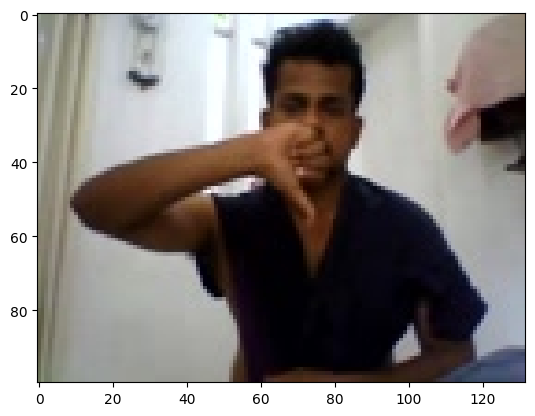

In [63]:
DATADIR = r"D:\TMS\dataset\egogesture\gestures\23\validation\subject12\1"
DATADIR2 = r"D:\TMS\dataset\jester\20bn-jester-v1\10"

# OTTENGO IL FRAME    
path_test = os.path.join(DATADIR2, '00024.jpg') 
frame_test = cv2.imread(path_test)  # convert to array
plt.imshow(cv2.cvtColor(frame_test, cv2.COLOR_BGR2RGB))      

#### hands


both hands kp shape: (126,)


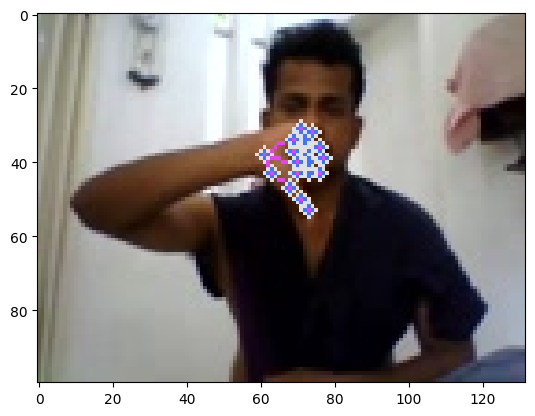

In [66]:
# ESTRAGGO I KEYPOINTS DA CIASCUN FRAME
with mp_hands.Hands(max_num_hands=2, min_detection_confidence=0.5) as hands:
    image_h_test, results_test = mediapipe_detection(frame_test, hands)
    
    annotated_image_test = image_h_test.copy()

    first_hand_keypoints_test = np.zeros(21*3)
    second_hand_keypoints_test = np.zeros(21*3)
    
    if results_test.multi_hand_landmarks:

        for num, hand_landmarks_test in enumerate(results_test.multi_hand_landmarks):        

            mp_drawing.draw_landmarks(     
                annotated_image_test,
                hand_landmarks_test,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(245,117,66), thickness=1, circle_radius=1),
                mp_drawing.DrawingSpec(color=(245,66,230), thickness=1, circle_radius=1)
                )

            if num == 0:   
                first_hand_keypoints_test = extract_keypoints_hands(results_test, hand_landmarks_test)
                #print("\n1st hand kp:", first_hand_keypoints_test)
            if num == 1:
                second_hand_keypoints_test = extract_keypoints_hands(results_test, hand_landmarks_test)
                #print("\n2nd hand kp:", second_hand_keypoints_test)

        keypoints_test = np.concatenate([first_hand_keypoints_test, second_hand_keypoints_test])

    else: keypoints_test = np.zeros(21*6)  

    print("\nboth hands kp shape:", keypoints_test.shape)  

    plt.imshow(cv2.cvtColor(annotated_image_test, cv2.COLOR_BGR2RGB))  

### Keypoints Shape: **126** 

abbiamo **63** keypoints per ogni mano, **126** per ogni frame:

- questo perchè se nessuna mano o una delle due non viene riconosciuta, verrà creato un vettore di zeri

## 7.2. HaGRID

In [ ]:
with mp_hands.Hands(max_num_hands = 1, min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as hands:  

    for label in hagrid_labels:
        label_path = os.path.join(DATADIR, str(label))
        list_frames = os.listdir(label_path)
        list_frames.remove("keypoints")

        print(label)

        for frame in list_frames:
            frame_path = os.path.join(label_path, frame)
                                
            img_array, img_num = get_and_append_img(LAST_CHAR, frame_path, frame)
            image_h, results = mediapipe_detection(img_array, hands)  

            first_hand_keypoints = np.zeros(21*3)
            second_hand_keypoints = np.zeros(21*3)

            #TODO aggiustare perchè if lo fa già extract_keypoints
            if results.multi_hand_landmarks:
                
                # num è il numero delle mani che riconosce!! 0 la prima, 1 eventualmente la seconda
                for num, hand_landmarks in enumerate(results.multi_hand_landmarks):              

                    if num == 0: # prima mano riconosciuta 
                        first_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)
                        #print("\n1st hand shape:", first_hand_keypoints.shape)

                    if num == 1: # seconda mano riconosciuta
                        second_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)
                        #print("\n2nd hand shape:", second_hand_keypoints.shape)

                keypoints = np.concatenate([first_hand_keypoints, second_hand_keypoints])                               

            else:
                print(results.multi_hand_landmarks)
                print("nessun kp trovato", frame_path)
                keypoints = np.concatenate([first_hand_keypoints, second_hand_keypoints])

            #print(keypoints)    

# 8. Preprocess Data and Create Labels and Features

Poichè stiamo trattando un **apprendimento supervisionato**, a ciascuno dei nostri video è associata una label, sia per l'insieme di Training che di Test.

Le label associate ai video dell'insieme di Test saranno trattate come un *ground truth*, per verificare, dopo l'apprendimento e la classificazione, se la predizione della label di ciascun video, ottenuta in output, è corretta o meno.

In [10]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [20]:
labels = np.concatenate((ego_labels, hagrid_labels))
labels

array(['Photo Frame', 'Applaud', 'Heart', 'ok', 'peace', 'rock',
       'victory', 'mano del gaucho', 'saluto', 'mute'], dtype='<U15')

Strutturiamo i dati fin qui raccolti, inserendoli in un unico array

## 8.1. EgoGesture


qui cicliamo separatamente per i video di training e test, avendoli già divisi:

In [12]:
GESTDIR = r'D:\TMS\dataset\egogesture\gestures'

In [38]:
def insert_all_in_array():

    train_videos_array = [] # X (feature input)
    test_videos_array = []

    for label in labels_num:
        label_path = os.path.join(GESTDIR, str(label))

        for set_fold in os.listdir(label_path):
            sets_path = os.path.join(label_path, set_fold)
            
            for subj in os.listdir(sets_path):
                subj_path = os.path.join(sets_path, subj)

                for vid in os.listdir(subj_path):
                    vid_path = os.path.join(subj_path, vid)

                    if subj in train_subjects_string:
                        train_window = []
                    elif subj in test_subjects_string:
                        test_window = []

                    kp_path = os.path.join(vid_path, "keypoints")
                    kp_fold = os.listdir(kp_path)

                    for kp in kp_fold:
                        npy_path = os.path.join(kp_path, kp)
                        res = np.load(npy_path)
                        #print("\n", npy_path, "\n", res)

                        if subj in train_subjects_string:   
                            train_window.append(res)                       
                        elif subj in test_subjects_string:        
                            test_window.append(res)                  

                    if subj in train_subjects_string:   
                        train_videos_array.append(train_window)                       
                    elif subj in test_subjects_string:        
                        test_videos_array.append(test_window)                          
                         

    return train_videos_array, test_videos_array

avremo così array di array di array: 
- per primo un grande array per ogni tipologia di video (train, test e validation) che contiene altri array
- tali array rappresentano i relativi video, che a loro volta contengono altri array
- questi array contengono i keypoints estratti da ogni frame di ogni video

In [39]:
train_videos_array, test_videos_array = insert_all_in_array()

In [61]:
train_videos_array = np.array(train_videos_array)
test_videos_array = np.array(test_videos_array)

In [40]:
print(np.array(train_videos_array).shape)
print(np.array(test_videos_array).shape)

(1392, 30, 126)
(360, 30, 126)


In [13]:
BASEDIR = r"C:\Users\follo\OneDrive\Documenti\GitHub\HGR-4-Social-Robotics"
ego_dir = os.path.join(BASEDIR, "mytempfiles", "egogesture_files")

In [42]:
np.save(os.path.join(ego_dir, "test_videos_array"), test_videos_array)
np.save(os.path.join(ego_dir, "train_videos_array"), train_videos_array)

In [53]:
train_videos_ego = np.load(os.path.join(ego_dir,"train_videos_array.npy"))
test_videos_ego = np.load(os.path.join(ego_dir,"test_videos_array.npy"))

#### creo dataframe che associ ogni video alla sua label, per quelli di test, train e validation

In [15]:
def apply_label(vid, label, videos_labels):

    #print("label:", label, "dict:", label_dict[label])
    videos_labels[label_dict[label]].append(vid)
       
    return videos_labels

In [16]:
GESTDIR = r"D:\TMS\dataset\egogesture\gestures"

#TODO: soluzione artigianale ma cambiare non si può vedere

train_videos_23 = []
train_videos_52 = []
train_videos_53 = []

test_videos_23 = []
test_videos_52 = []
test_videos_53 = []

videos_labels_train = [train_videos_23, train_videos_52, train_videos_53]
videos_labels_test = [test_videos_23, test_videos_52, test_videos_53]

for label in labels_num:
    label_path = os.path.join(GESTDIR, str(label))

    for set_fold in os.listdir(label_path):
        sets_path = os.path.join(label_path, set_fold)
        
        for subj in os.listdir(sets_path):
            subj_path = os.path.join(sets_path, subj)

            for vid in os.listdir(subj_path):         
                
                if subj in train_subjects_string:
                    apply_label(vid, int(label), videos_labels_train)
                elif subj in test_subjects_string:
                    apply_label(vid, int(label), videos_labels_test)        

#in videos_labels_x[i] ci sono tutti i video per ogni label i-esima
sum_train = 0
for i in range(0, 3):
    #print("\ntrain:", labels_num[i], sorted(videos_labels_train[i], key = int))
    print(labels_num[i], len(videos_labels_train[i]))
    sum_train += len(videos_labels_train[i])
print("sum train:", sum_train, "\n")

sum_test = 0
for i in range(0, 3):
    #print("\ntest:", labels_num[i], sorted(videos_labels_test[i], key = int))
    print(labels_num[i], len(videos_labels_test[i]))
    sum_test += len(videos_labels_test[i])
print("sum test:", sum_test, "\n")

23 464
52 462
53 466
sum train: 1392 

23 120
52 120
53 120
sum test: 360 



##### quante occorrenze per ogni gesto?

- **23**: 584
    - *training*: 464
    - *test*: 120    
- **52**: 582
    - *training*: 462
    - *test*: 120
- **53**: 586
    - *training*: 466
    - *test*: 120    

##### creo le label da associare ad ogni video e da dare in input alla rete neurale LSTM:
- poichè i video sono ordinati per label, mi basta creare un dataframe dove concateno il nome di tutte le label per x volte
    - ovvero per tutti i video che ho per quella classe (scritto sopra)

In [17]:
# uso le label categoriche al posto di quelle numeriche (TODO SUPERFLUO, ma c'è codice già scritto sotto...)
train_label_23 = [ego_labels[0]] * 464
train_label_52 = [ego_labels[1]] * 462
train_label_53 = [ego_labels[2]] * 466

# creata lista che contiene tutte le occorrenze di ogni label, già ordinate (come scritto sopra)
train_labels_list = train_label_23+train_label_52+train_label_53

# creo dataframe
train_label_df = pd.DataFrame(train_labels_list, columns=["label"])
print(train_label_df)

            label
0     Photo Frame
1     Photo Frame
2     Photo Frame
3     Photo Frame
4     Photo Frame
...           ...
1387        Heart
1388        Heart
1389        Heart
1390        Heart
1391        Heart

[1392 rows x 1 columns]


In [18]:
# uso le label categoriche al posto di quelle numeriche (TODO SUPERFLUO, ma c'è codice già scritto sotto...)
test_label_23 = [ego_labels[0]] * 120
test_label_52 = [ego_labels[1]] * 120
test_label_53 = [ego_labels[2]] * 120

# creata lista che contiene tutte le occorrenze di ogni label, già ordinate (come scritto sopra)
test_labels_list = test_label_23+test_label_52+test_label_53

# creo dataframe
test_label_df = pd.DataFrame(test_labels_list, columns=["label"])
print(test_label_df)

           label
0    Photo Frame
1    Photo Frame
2    Photo Frame
3    Photo Frame
4    Photo Frame
..           ...
355        Heart
356        Heart
357        Heart
358        Heart
359        Heart

[360 rows x 1 columns]


## 8.2. HaGRID

In [22]:
label_map = {label:num for num, label in enumerate(labels)}

In [35]:
label_map = {"ok": 3, 'peace': 4, 'rock': 5,
 'victory': 6,
 'mano del gaucho': 7,
 'saluto': 8,
 'mute': 9}

In [39]:
#all_kp = []
labels_list = []

for label in hagrid_labels:
    label_path = os.path.join(DATADIR, str(label)) 
    kp_path = os.path.join(label_path, "keypoints")
    print(label)

    window = [] 
    
    if not label == "mute":
        for kp_num in range(1, 23130): #prendo i primi 23130 di ogni label, per avere un numero uguale di array-kp
            #kp = (str(kp_num)).zfill(5) + ".npy"
            #res = np.load(os.path.join(kp_path, kp))
            #window.append(res)      
            labels_list.append(label_map[label])
    else:
        for kp in os.listdir(kp_path):
            labels_list.append(label_map[label])

    #all_kp.append(window)    

ok
peace
rock
victory
mano del gaucho
saluto
mute


In [ ]:
np.array(window).shape

(23129, 126)

In [ ]:
np.array(all_kp).shape

(4, 23129, 126)

In [ ]:
all_kp_copy = np.array(all_kp).copy()
all_kp_copy.shape

(4, 23129, 126)

In [ ]:
X = all_kp_copy.reshape((4*23129), 126)
X.shape

(92516, 126)

In [40]:
np.array(labels_list).shape

(153081,)

In [48]:
y_hagrid = np.array(labels_list)

In [42]:
BASEDIR = r"C:\Users\follo\OneDrive\Documenti\GitHub\HGR-4-Social-Robotics"

In [ ]:
np.save(os.path.join(BASEDIR, "mytempfiles","X_array"), X)
np.save(os.path.join(BASEDIR, "mytempfiles","y_array"), y)

In [46]:
X_hagrid = np.load(os.path.join(BASEDIR, "mytempfiles", "X_array.npy"))
y_hagrid = np.load(os.path.join(BASEDIR, "mytempfiles", "y_array.npy"))

dobbiamo ora splittare l'array dei keypoints, X, e la lista delle label associate a ciascun frame, y, negli insiemi di train e test

splittiamo mantenendo la proporzione:
- 80% train
- 20% test

In [49]:
X_train_hagrid, X_test_hagrid, y_train_hagrid, y_test_hagrid = train_test_split(X_hagrid, y_hagrid, test_size=0.2, stratify=y_hagrid, random_state=11)

In [ ]:
y = to_categorical(labels_list).astype(int)

In [50]:
print(X_test_hagrid.shape)
print(X_train_hagrid.shape)
print(y_test_hagrid.shape)
print(y_train_hagrid.shape)

(30617, 126)
(122464, 126)
(30617,)
(122464,)


avremo così:
- **122464** immagini di train
- **30617** immagini di test

## Create Input for our LSTM model

Dovremo concatenare le strutture dati ottenute per ogni dataset, al fine di ottenere:
- per la variabile indipendente **X**, un array dove sono contenuti tutti i keypoints di tutti i video di ciascun dataset
- per la variabile dipendente **Y**, una lista di label correttamente associate ai video di X

In [51]:
labels = np.concatenate((ego_labels, hagrid_labels))
labels

array(['Photo Frame', 'Applaud', 'Heart', 'ok', 'peace', 'rock',
       'victory', 'mano del gaucho', 'saluto', 'mute'], dtype='<U15')

### Variabile indipendente, X

devo fare reshape di EgoGesture, essendo gli array in "formato video", moltiplicando ogni sequenza (30) per il numero di video totali, in modo da ottenere il **numero totale dei frame**

In [54]:
train_videos_ego = train_videos_ego.reshape((1392*30), 126)
test_videos_ego = test_videos_ego.reshape((360*30), 126)

In [56]:
print(train_videos_ego.shape)
print(test_videos_ego.shape)

(41760, 126)
(10800, 126)


vediamo quindi che così facendo, per EgoGesture, avremo:
- **41760** frame di training
- **10800** frame di test

In [57]:
X_train = np.concatenate((train_videos_ego, X_train_hagrid))
X_test = np.concatenate((test_videos_ego, X_test_hagrid))

In [58]:
print(X_train.shape)
print(X_test.shape)

(164224, 126)
(41417, 126)


### Variabile dipendente, Y

Concateno i due dataframe ottenuti precedentemente:

In [59]:
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
label_train_ego = le.fit_transform(train_label_df["label"]) 
label_test_ego = le.fit_transform(test_label_df["label"])

In [60]:
label_train_ego_list = np.repeat(label_train_ego.tolist(), 30)
label_test_ego_list = np.repeat(label_test_ego.tolist(), 30)

In [61]:
label_train_ego = np.array(label_train_ego_list)
label_test_ego = np.array(label_test_ego_list)

In [62]:
print(label_train_ego.shape)
print(label_test_ego.shape)

(41760,)
(10800,)


trasformo feature categoriche in feature numeriche (One Hot Encoding)

In [63]:
y_train_ego = to_categorical(label_train_ego).astype(int)
y_test_ego = to_categorical(label_test_ego).astype(int)

In [119]:
print(y_train_ego.shape)
print(y_test_ego.shape)

(1392, 3)
(360, 3)


In [105]:
y_train_hagrid.shape

(122464,)

In [64]:
y_train = np.concatenate((label_train_ego, y_train_hagrid))
y_test = np.concatenate((label_test_ego, y_test_hagrid))

In [76]:
y_train.tolist().count(2)

13920

In [77]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(164224, 126)
(41417, 126)
(164224,)
(41417,)


# 9. Build and Train a Classification Model

## 9.1 Using Machine Learning

In [78]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, LeaveOneGroupOut

from sklearn.utils import shuffle

In [79]:
# Metriche di valutazione
from sklearn.metrics import ConfusionMatrixDisplay 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

### Random Forest

In [80]:
pipeline = imbpipeline(steps = [['classifier', RandomForestClassifier(max_depth=None, random_state=None)]]) 

In [81]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=12)

In [82]:
# in param_grid sono definiti gli iperparametri
param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [4, 6, 10, 12],
                }

new_params = {'classifier__' + key: param_grid[key] for key in param_grid}

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=new_params,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           verbose = 5,
                           n_jobs=-1) # utilizzerà tutti i processori disponibili

In [83]:
# troviamo il modello migliore
grid_search.fit(X_train, y_train)

cv_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f'Best parameters: {best_params}')
print(f'Cross-validation score: {cv_score}')

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters: {'classifier__max_depth': 12, 'classifier__n_estimators': 200}
Cross-validation score: 0.8583337339330971


In [84]:
y_test_predict = grid_search.predict(X_test)

In [85]:
y_test_predict_prob=grid_search.predict_proba(X_test)

accuracy: 0.8554216867469879
precision: 0.8802587011474639
recall: 0.848924598786882
f1: 0.8508460486068351


[]

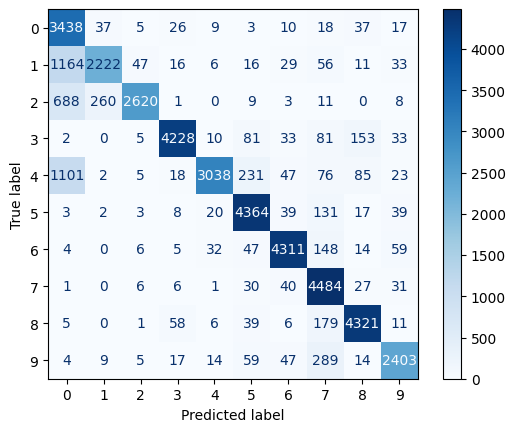

In [86]:
# calcoliamo le metriche di valutazione
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='macro')
recall = recall_score(y_test, y_test_predict, average='macro')
f1 = f1_score(y_test, y_test_predict, average='macro')

ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_test_predict, 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')


plt.plot()

## 9.2 Using Deep Learning

Addestriamo la rete neurale (ricorrente) **LSTM**: 

- perchè usare MediaPipe Holistic + una rete neurale LSTM?
    - occorrono *meno dati*
    - più *veloce* nell'addestramento
    - riconoscimento più *veloce* <- RN più *semplice*

In [160]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard
from keras.layers import Dropout

**TensorBoard** ci offre una web app per monitorare il nostro modello: addestramento, accuratezza, ... 

In [189]:
BASEDIR = r"C:\Users\follo\OneDrive\Documenti\GitHub\HGR-4-Social-Robotics"

In [190]:
log_dir = os.path.join(BASEDIR, "Logs")
tb_callback = TensorBoard(log_dir=log_dir)

In [250]:
# il modello Sequential ci permette di aggiungere layer in maniera organizzata e facile
model = Sequential()

#tre layer LSTM
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape = (30, 126))) #64 unità
model.add(LSTM(128, return_sequences=True, activation='relu')) #return_sequences è necessario per il passaggio di dati al layer successivo
model.add(LSTM(64, return_sequences=False, activation='relu'))

#droppiamo casualmente dei nodi
#model.add(Dropout(0.5))

#tre layer Dense
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(labels.shape[0], activation='softmax')) #distribuzione di probabilità che assegna ad ogni azione una certa prob.

Compiliamo il modello, usando:

- loss function: "categorical cross entropy"
    - è obbligatoria per classificazione multi-classe

In [251]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [252]:
model_temp = model.fit(X_train, y_train, epochs = 150, callbacks=[tb_callback])

Epoch 1/150
113/113 [==============================] - 12s 60ms/step - loss: 1.4210 - categorical_accuracy: 0.5025
Epoch 2/150
113/113 [==============================] - 7s 58ms/step - loss: 0.9969 - categorical_accuracy: 0.6345
Epoch 3/150
113/113 [==============================] - 7s 60ms/step - loss: 0.7986 - categorical_accuracy: 0.7135
Epoch 4/150
113/113 [==============================] - 7s 59ms/step - loss: 0.7068 - categorical_accuracy: 0.7467
Epoch 5/150
113/113 [==============================] - 7s 60ms/step - loss: 0.8579 - categorical_accuracy: 0.7018
Epoch 6/150
113/113 [==============================] - 7s 60ms/step - loss: 0.7371 - categorical_accuracy: 0.7238
Epoch 7/150
113/113 [==============================] - 7s 59ms/step - loss: 0.6234 - categorical_accuracy: 0.7703
Epoch 8/150
113/113 [==============================] - 7s 59ms/step - loss: 0.6090 - categorical_accuracy: 0.7803
Epoch 9/150
113/113 [==============================] - 7s 59ms/step - loss: 0.5798 - ca

In [204]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 64)            48896     
                                                                 
 lstm_7 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_8 (LSTM)               (None, 64)                49408     
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 7)                 231       
                                                                 
Total params: 203,591
Trainable params: 203,591
Non-tr

# 10. Make Predictions

In [87]:
IMGDIR = r"C:\Users\follo\OneDrive\Desktop\rock.jpg"

image = cv2.imread(IMGDIR)
image_resized = image_resize(image, height = 240)  
#plt.imshow(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)) 

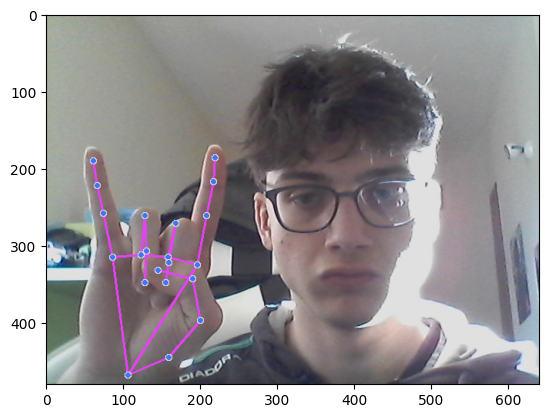

In [88]:
LAST_CHAR = 5

# OTTENGO IL FRAME 
with mp_hands.Hands(max_num_hands = 1, min_detection_confidence=0.5, min_tracking_confidence = 0.5) as hands:   
    
    image_h, results = mediapipe_detection(image, hands)     
    
    annotated_image = image_h.copy()                  

    first_hand_keypoints = np.zeros(21*3)
    second_hand_keypoints = np.zeros(21*3)

    #TODO aggiustare perchè if lo fa già extract_keypoints
    if results.multi_hand_landmarks:
        
        # num è il numero delle mani che riconosce!! 0 la prima, 1 eventualmente la seconda
        for num, hand_landmarks in enumerate(results.multi_hand_landmarks):   

            mp_drawing.draw_landmarks(     
                annotated_image,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                )

            if num == 0: # prima mano riconosciuta 
                first_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)
                #print("\n1st hand shape:", first_hand_keypoints.shape)

            if num == 1: # seconda mano riconosciuta
                second_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)
                #print("\n2nd hand shape:", second_hand_keypoints.shape)

        keypoints = np.concatenate([first_hand_keypoints, second_hand_keypoints])                               

    else:
        print("nessun kp trovato")
        keypoints = np.concatenate([first_hand_keypoints, second_hand_keypoints])

    #print(keypoints)    
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))  

In [89]:
res = grid_search.predict_proba([keypoints])
print(res)
print("idx:", np.argmax(res))
print(labels[np.argmax(res)])
print(res[0][np.argmax(res)])

[[0.14937777 0.06727101 0.15420442 0.02534917 0.10468887 0.37591115
  0.00629044 0.00607009 0.06875388 0.0420832 ]]
idx: 5
rock
0.37591115084973076


# 11. Save Weights

In [208]:
model.save(os.path.join(BASEDIR, "models_action", 'final_nodrop.h5'))

In [ ]:
del model

In [21]:
model.load_weights(os.path.join(BASEDIR, "models_action", 'egoactions2.h5'))

# 12. Evaluation using Confusion Matrix and Accuracy

In [47]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

In [257]:
yhat = model.predict(X_test)

24/24 [==============================] - 1s 23ms/step


In [258]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [259]:
accuracy_score(ytrue, yhat)

0.8366800535475234

In [260]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[626,   1],
        [ 26,  94]],

       [[625,   2],
        [ 27,  93]],

       [[627,   2],
        [ 20,  98]],

       [[626,   1],
        [ 25,  95]],

       [[606,   8],
        [ 24, 109]],

       [[503, 108],
        [  0, 136]]], dtype=int64)

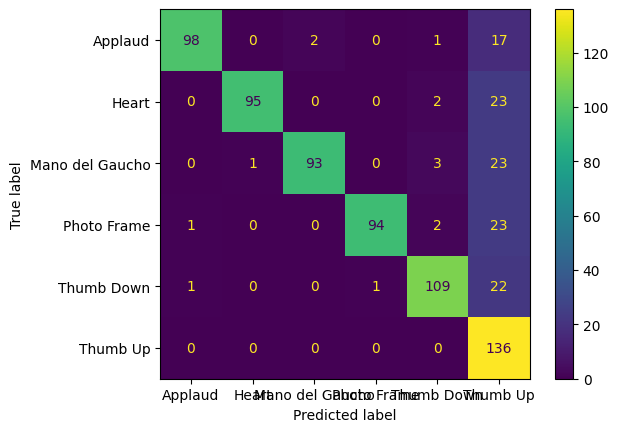

In [261]:
ConfusionMatrixDisplay.from_predictions(labels[ytrue], labels[yhat])

# 13. Test in Real Time

In [90]:
colors = [(245,117,16), (117,245,16), (16,117,245), (56,125,200), (88,22,152), (50,180,255), (100,180,255), (100,180,255), (100,180,255), (100,180,255)]
def prob_viz(res, jester_gestures, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, jester_gestures[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [91]:
# 1. New detection variables
sequence = []
predictions = []
gesto = ""
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_hands.Hands(max_num_hands=2, min_detection_confidence=0.5) as hands:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        if not ret:
            print("Ignoring empty camera frame.")
            # If loading a video, use 'break' instead of 'continue'.
            continue
        
        # Make detections
        image, results = mediapipe_detection(frame, hands)
        print(results)        
        print("which hand?", results.multi_handedness)

        first_hand_keypoints = np.zeros(21*3)
        second_hand_keypoints = np.zeros(21*3)
    
        if results.multi_hand_landmarks:
            for num, hand_landmarks in enumerate(results.multi_hand_landmarks):        

                mp_drawing.draw_landmarks(     
                    image,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
                    mp_drawing.DrawingSpec(color=(200,66,230), thickness=2, circle_radius=2)
                    )
                
                if num == 0:   
                    first_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)
                    #print("\n1st hand kp:", first_hand_keypoints_test)
                if num == 1:
                    second_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)
                    #print("\n2nd hand kp:", second_hand_keypoints_test)

            keypoints = np.concatenate([first_hand_keypoints, second_hand_keypoints])    

        else: 
            keypoints = np.zeros(21*6)
            print("no detect")
                        
        # 2. Prediction logic
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = grid_search.predict_proba([keypoints])
            res = res[0] # è contenuto in un array | TODO togliere
            print(labels[np.argmax(res)])
            predictions.append(np.argmax(res))
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold:                     
                    gesto = labels[np.argmax(res)]
             
            # Viz probabilities
            image = prob_viz(res, labels, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(gesto), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no